# PROJECT-3. Сегментация космических аппаратов

This project is based on ["A Spacecraft Dataset for Detection, Segmentation, and Parts Recognition"](https://github.com/Yurushia1998/SatelliteDataset). The annotations only allow to perform semantic segmentation as all instances of the same class are included in one common binary mask.

During the project the examination of a variety of models were perfromed - DeepLabV3 (LRASPP, MobileNetV3 and ResNet50) and FCN (ResNet50) models from [Pytorch](https://pytorch.org/vision/stable/models.html#semantic-segmentation), YOLOv8 and Segment Anything Model.

1. Semantic segmentation models available in Pytorch are fine-tuned similarly, but require gradient enabling in the whole net to gain better result: "We fine-tune all layers by backpropagation through the whole net. Fine-tuning the output classifier alone yields only 70% of the full finetuning performance" (https://arxiv.org/pdf/1411.4038.pdf).

2. YOLO family models are based on contour annotations which might be obtained from existing masks by means of OpenCV. This option wasn't fully implemented due to techincal issues with annotaion transformation.

3. Semantic segmentation by SAM is not directly supported what is stated by its creators in the [description:](https://arxiv.org/abs/2304.02643) "While SAM can perform many tasks, it is unclear how to design simple prompts that implement semantic and panoptic segmentation." Also transfer learning can't be implemented straightforward because of decorator torch.no_grad() before SamPredictor.predict_torch function as it disables gradients computations. Nevertheless such attempt was performed based on the [suggested solution](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/). This try didn't show acceptable result with reasonable efforts. Fine-tuning was attempted with bounding boxes obtained from available binary masks.

This notebook is based on [the project](https://www.kaggle.com/code/dkudryavtsev/spacecraft-component-segmentation). Function for IoU computation was improved for calculation clarity and better averaging. Semantic segmantation is performed by FCN_ResNet50 as it showed the best result within 10 epochs (free GPU resources are limited in Google Colab).

In [1]:
!pip install -qqq pytorch_lightning

In [2]:
#########1#########2#########3#########4#########5#########6#########7#########

import os
import numpy as np
import random
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from tqdm import tqdm

# seed for reproducibility
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

DATA = Path('spacecraft')
BATCH_SIZE = 8 if torch.cuda.is_available() else 4

## Dataset loading

In [3]:
!gdown 1e1TjZVh0kLPl64dTpOentAL42dnfxnSE
!unzip -o -q spacecraft.zip
!ls -1 {DATA}/*

Downloading...
From: https://drive.google.com/uc?id=1e1TjZVh0kLPl64dTpOentAL42dnfxnSE
To: /content/spacecraft.zip
100% 2.53G/2.53G [00:17<00:00, 148MB/s]
spacecraft/all_bbox.txt
spacecraft/ReadMe.txt

spacecraft/images:
train
val

spacecraft/mask:
train
val


## PyTorch Dataset

The original RGB masks are one-hot encoded to tensors of the \[C, H, W\] dimensions with four (C=4) channels: one background and three classes. Some images in the dataset have 4 channels. All pixels in the fourth channel are equal to 255 which doesn't bring any value for the model.

In [4]:
class SpacecraftDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.image_dir = data_dir / 'images' / split
        self.mask_dir = data_dir / 'mask' / split
        self.image_filenames = sorted(self.image_dir.glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        # Some images in dataset have 4 channels, using first 3 only
        image = np.array(Image.open(image_filename))[..., :3]

        mask_filename = (
                self.mask_dir/
                    str(image_filename.name.split('.')[0] + '_mask.png'))
        masks = np.array(Image.open(mask_filename))

        # Mask one-hot encoding: background + 3 classes
        masks[masks!=0] = 1
        foreground = np.ubyte(np.sum(masks, axis=2))
        background = foreground^1
        background = background[:, :, np.newaxis]
        masks = (np.concatenate((background, masks), axis=2)
                    .astype(np.float32))

        transformed = self.transform(image=image, mask=masks)
        image = transformed['image']
        masks = transformed['mask'].permute(2, 0, 1)
        masks = masks.bool().float()

        return image, masks

### Augmentations and transformations

Augmentation of the training dataset. We also resize the images to 520 x 520 px and normalize them with the default mean and std values which is source image format for all semantic segmentation models in Pytorch:

from torchvision.transforms._presets import SemanticSegmentation

transforms=partial(SemanticSegmentation, resize_size=520)

In [5]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomCropFromBorders(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.ISONoise(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25),
        A.AdvancedBlur(),
        A.RandomBrightnessContrast(brightness_limit=[-0.3, 0.1])
    ]),
    A.Resize(520, 520),
    A.RandomRotate90(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])

valid_transforms = A.Compose([
    A.Resize(520, 520),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = SpacecraftDataset(DATA, transform=train_transforms, split='train')
valid_dataset = SpacecraftDataset(DATA, transform=valid_transforms, split='val')

### Visualization of images, augmentations, and masks

Here are the functions that randomly display our images (augmented for the training dataset and original for the validation). Notice that the images both feeded to the network and the inference are actually of the 520x520 size, but for visualization we restore their original format. The function "predict_mask" returns the predicted mask calculated from the output logits of the network.

In [6]:
def denormalize(image, mask, size=(720, 1280)):
    """Converts a normalized torch.Tensor image
       to a "H,W,C" array of integers [0-255]
       Restores the original image size (1280x720)
    """
    transform = A.Compose([
        A.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225 ],
                    max_pixel_value=1.),
        A.Normalize(mean=[-0.485, -0.456, -0.406], std=[ 1., 1., 1. ],
                    max_pixel_value=1.),
        A.Resize(*size)
    ])

    image = image.numpy().transpose((1, 2, 0))
    mask = mask[1:,:,:].numpy().transpose((1, 2, 0))
    transformed = transform(image=image, mask=mask)
    image = transformed['image']
    mask = transformed['mask']
    image = (image * 255).astype(np.uint8)

    return np.ascontiguousarray(image), np.ascontiguousarray(mask)


def predict_mask(model, image):
    """Predicting a mask
    """
    model.eval()
    model.to('cpu')

    # predict logits [C, H, W]
    with torch.no_grad():
        pred_mask = model(image.unsqueeze(0))['out'].squeeze(0)

    # class for each pixel [H, W]
    pred_mask = pred_mask.argmax(dim=0)

    # one-hot [H, W, C]
    pred_mask = torch.eye(4)[pred_mask.to(torch.int64)]

    # background removed [H, W, 3 channels] == RGB image
    pred_mask = pred_mask[:,:,1:].numpy()

    transform = A.Resize(720, 1280)
    image = image.numpy().transpose((1, 2, 0))
    pred_mask = transform(image=image, mask=pred_mask)['mask']

    return pred_mask


def display_random_examples(dataset, n=2, model=None):
    if model is None:
        fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 3 * n))
    else:
        fig, ax = plt.subplots(nrows=n, ncols=3, figsize=(15, 3 * n))

    for i in range(n):
        img_tensor, mask_tensor = dataset.__getitem__(np.random.randint(len(dataset)))
        image, mask = denormalize(img_tensor, mask_tensor)

        ax[i, 0].imshow(image)
        ax[i, 1].imshow(image)
        ax[i, 1].imshow(mask, alpha=0.5)

        ax[i, 0].set_title('Image')
        ax[i, 1].set_title('Mask')

        if model is not None:
            ax[i, 2].imshow(image)
            ax[i, 2].imshow(
                predict_mask(model, img_tensor), alpha=0.5)
            ax[i, 2].set_title('Predicted mask')

    [axi.set_axis_off() for axi in ax.ravel()]
    plt.tight_layout()
    plt.show()

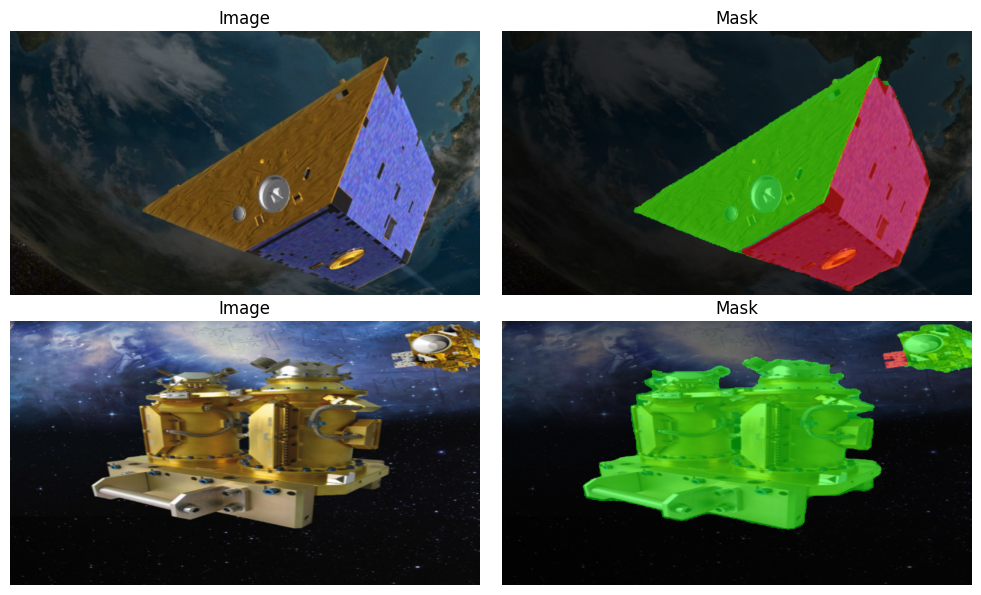

In [7]:
display_random_examples(train_dataset)

### The intersection-over-union metric for multi-class binary masks

In [8]:
def IoU(logits, gt_binary_masks, eps: float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.

    Notes: [Batch size, Num classes, Height, Width]
    Args:
        gt_binary_masks: a tensor of shape [B, C, H, W]. C==0 is the background class
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = logits.shape[1]

    # class for each pixel [H, W]
    encoded_masks = logits.argmax(dim=1)

    # one-hot [H, W, C]
    binary_masks = torch.eye(num_classes, device=encoded_masks.device)[encoded_masks.to(torch.int64)].permute(0,3,1,2)

    gt_binary_masks = gt_binary_masks.to(binary_masks.device)

    # Sum probabilities by class and across batch images
    # Sum up by class dims==1, dims==0 is for batch
    dims = tuple(range(2, gt_binary_masks.ndimension()))
    # Excluding C==0 (background class)
    intersection = torch.sum(torch.logical_and(binary_masks[:,1:,:,:], gt_binary_masks[:,1:,:,:]), dims)
    union = torch.sum(torch.logical_or(binary_masks[:,1:,:,:], gt_binary_masks[:,1:,:,:]), dims)
    iou = (intersection / (union+eps))

    # Updating IoU values with NaN where object class is not present for proper averaging
    for idx, item in enumerate(iou):
        for c, _ in enumerate(item):
            if gt_binary_masks[idx, c + 1].sum() == 0:
                iou[idx, c] = float('nan')
    return iou.nanmean()

### Custom [PyTorch Lighnting module](https://pytorch-lightning.readthedocs.io/en/2.0.5/common/lightning_module.html)

We use the cross entropy loss function and evaluate the results with the intersection over union metric.

The optimizer is Adamax (Adam with the infinity norm). We also set the initial learning rate to vary at the beginning of the epochs according to the "cosine annealing with warm restarts" schedule. This procedure results in better metrics according to several experiments performed (not reflected here): it seems like the initial learning rate influences the performance of the Adam optimizer, and one can never know what the rate is the best. These variations help to get the optimal initial learning rate at least for some epochs, which helps achive better and more stable convergence.

In [9]:
class SegModel(pl.LightningModule):
    def __init__(self, model, batch_size, lr, train_dataset, valid_dataset):
        super(SegModel, self).__init__()
        pl.seed_everything(seed=42, workers=True)
        self.net = model
        self.batch_size = batch_size
        self.learning_rate = lr
        self.trainset = train_dataset
        self.valset = valid_dataset
        self.criterion = torch.nn.CrossEntropyLoss()


    def forward(self, x):
        return self.net(x)


    def training_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)['out'] # [B, C, H, W]
        loss_val = self.criterion(out, mask)
        iou_score = IoU(out, mask)
        self.log('train_loss', loss_val, prog_bar=True)
        self.log('train_iou', iou_score, prog_bar=True)
        return loss_val


    def configure_optimizers(self):
        opt = torch.optim.Adamax(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10)
        return [opt], [sch]


    def train_dataloader(self):
        return DataLoader(self.trainset,
                          drop_last=True,  # drop last incomplete batch
                          batch_size=self.batch_size,
                          shuffle=True, num_workers=os.cpu_count())


    def val_dataloader(self):
        return DataLoader(self.valset,
                          drop_last=True,  # drop last incomplete batch
                          batch_size=self.batch_size,
                          shuffle=False, num_workers=os.cpu_count())


    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)['out']
        loss_val = self.criterion(out, mask)
        iou_score = IoU(out, mask)
        self.log('val_loss', loss_val, prog_bar=True)
        self.log('val_iou', iou_score, prog_bar=True, on_epoch=True)

## Fully-Convolutional Network model with a ResNet-50 backbone

We use the PyTorch implementation of the [Fully-Convolutional Network model with a ResNet-50 backbone](https://pytorch.org/vision/main/models/generated/torchvision.models.segmentation.fcn_resnet50.html#torchvision.models.segmentation.fcn_resnet50)

 (35.3 mln parameters, 152.72 GFLOPS). Although the dataset is quite different from COCO, which the model has been trained with, the use of the pretrained weights is beneficial. We change the output layers of the classifiers to fit our 3 classes+background and make all the parameters to be trainable.

In [10]:
model = torchvision.models.segmentation.fcn_resnet50(
    weights='DEFAULT')

model.classifier[4] = nn.Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))

all_params = sum(p.numel() for p in model.parameters())
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'No of parameters: {all_params}')
print(f'No of trainable parameters: {train_params}')

No of parameters: 35309128
No of trainable parameters: 35309128


In [11]:
print(model.classifier)
print(model.aux_classifier)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
)
FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
)


### Model training

Training of the model. Additionally here we estimate the initial learning rate and maximum batch size using the PyTorch Lightning Tuner (this affects only the very first estimation of the learning rate and does not interfere with the scheduler or Adam algorithms).

In [17]:
# The model
pl_model = SegModel(model, BATCH_SIZE, 0.001, train_dataset, valid_dataset)

# Pytorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=10,
    log_every_n_steps=10,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_iou'),
        LearningRateMonitor('epoch'),
        EarlyStopping(monitor='val_iou', mode='max', patience=15),
    ],
)

# Batch size and initial learning rate estimation
tuner = pl.tuner.Tuner(trainer)
tuner.lr_find(pl_model)

# Model training
start_time = time.time()
trainer.fit(pl_model)
duration = time.time() - start_time
print('Training finished, duration: {:.0f}m {:.0f}s'.format(duration // 60, duration % 60))

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0007585775750291836
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_b9ff6212-2a99-4ce5-a92c-4fbedcf95604.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_b9ff6212-2a99-4ce5-a92c-4fbedcf95604.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | net       | FCN              | 35.3 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.237   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Training finished, duration: 118m 46s


In [47]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir 'lightning_logs/'

<IPython.core.display.Javascript object>

### Validation

In [19]:
trainer.validate(pl_model, dataloaders=pl_model.val_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.7571325302124023     │
│         val_loss          │    0.07550717145204544    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.07550717145204544, 'val_iou': 0.7571325302124023}]

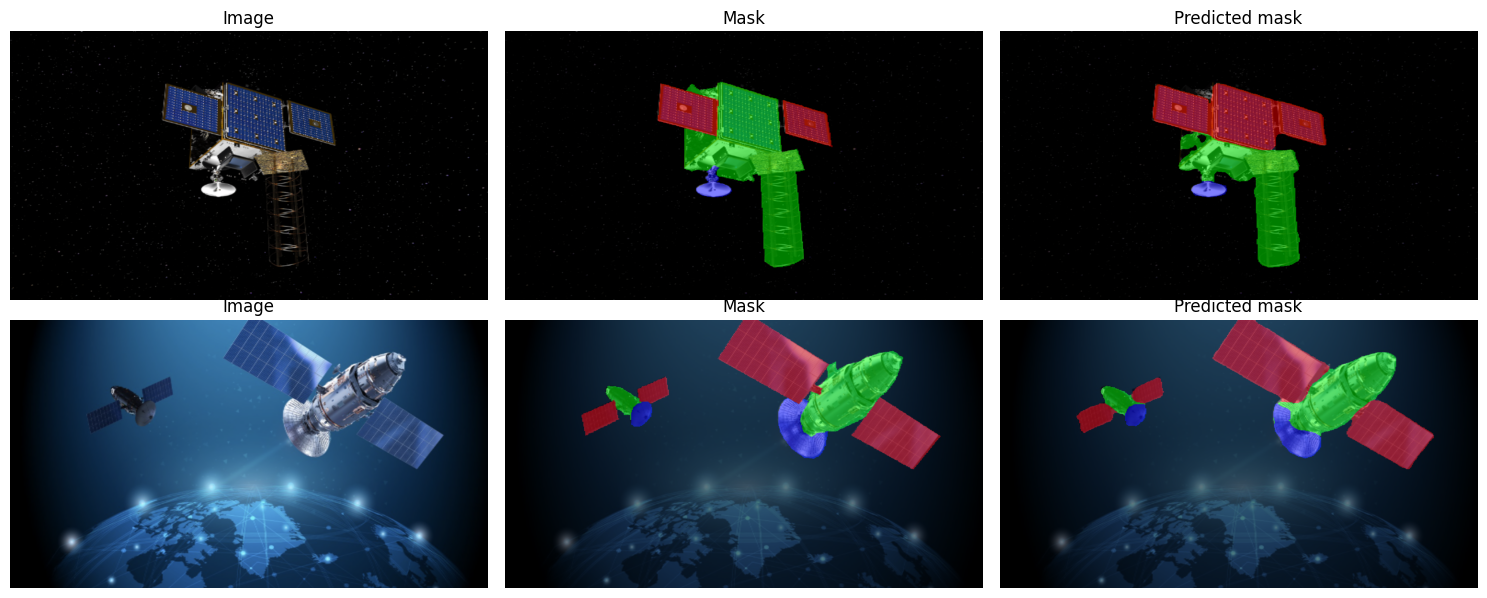

In [26]:
display_random_examples(valid_dataset, 2, pl_model)

### Conclusion

A model for semantic segmentation of spacecraft components (body, solar panels, antennas) has been constructed based on the pretrained FCN ResNet50 network. An IOU metric of 0.75 has been achieved.

Also there is a space for improving dataset quality. As an example some images have embedded solar panels which are included in annotations in some masks only (images/train/img_resize_32.png and mask/train/img_resize_32_mask.png). In the first random example we can see that our model recognizes embedded solar panel while it's not the part of true mask.